Testing Images

In [57]:
import cv2
import os
import numpy as np
from PIL import Image
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences

Detecting and Extracting Face 

1/1 [==============================] - 0s 146ms/step


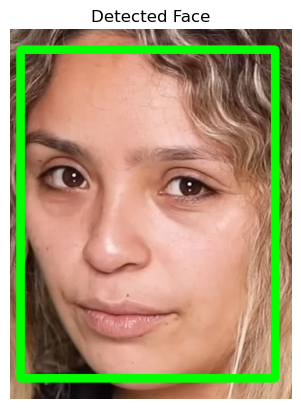

Face Extraction Completed!


In [58]:
def detect_faces_in_folder(source_directory, destination_directory):

    # All files in the folder
    files = os.listdir(source_directory)

    for image_file in files:

        image_path = os.path.join(source_directory, image_file)

        # Reading the image
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        detector = MTCNN()
        
        faces = detector.detect_faces(image) #Detect faces
        
        # Draw bounding boxes on the image
        for face in faces:
            bounding_box = face['box']
            cv2.rectangle(
                image_rgb,
                (bounding_box[0], bounding_box[1]),
                (bounding_box[0] + bounding_box[2], bounding_box[1] + bounding_box[3]),
                (0, 255, 0),  # BGR color format: Green color
                10  # Thickness of the rectangle
            )

        # Display the image with bounding boxes
        plt.imshow(image_rgb)
        plt.axis('off')  # Turn off axis labels and ticks
        plt.title('Detected Face')
        plt.show()

        for idx, face in enumerate(faces):
                bounding_box = face['box']
                x, y, w, h = bounding_box

                min_face_size = 45
                if w > min_face_size and h > min_face_size:
                    extracted_face = image[y:y + h, x:x + w]

                    extracted_face_filename = f'{os.path.splitext(image_file)[0]}_face{idx}.jpg'
                    extracted_face_path = os.path.join(destination_directory, extracted_face_filename)

                    cv2.imwrite(extracted_face_path, extracted_face)
                    print("Face Extraction Completed!")
                else:
                    print(f"Face in {image_file} is too small and will be skipped.")

#Image Path
source_directory = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\A_testing\\input_image'
destination_directory = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\A_testing\\face_image'
detect_faces_in_folder(source_directory, destination_directory)

Resizing Face

In [59]:
def resize_images(input_folder, output_folder, target_size):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
 
    # Loop through all files in the input folder
    for filename in os.listdir(input_folder):
        try:
            # Open the image file
            image_path = os.path.join(input_folder, filename)
            with Image.open(image_path) as img:
                # Resize the image
                resized_img = img.resize(target_size, Image.LANCZOS)

                # Save the resized image to the output folder
                output_path = os.path.join(output_folder, filename)
                resized_img.save(output_path)
                print(f"Resized and saved: {filename}")
        except Exception as e:
            print(f"Error resizing {filename}: {e}")

if __name__ == "__main__":
    # Set input and output folders and target size
    input_folder = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\A_testing\\face_image'
    output_folder = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\A_testing\\face_resized'
    
    target_size = (224, 224)  # Set the target size (width, height)
    # Resize images in the input folder and save to the output folder
    resize_images(input_folder, output_folder, target_size)

Resized and saved: 1_face0.jpg


In [60]:
#Enter Image Lighting Condition
lighting = "poorly"

Loading Model

In [61]:
folder_path = 'E:\\University\\FYP Stuff\\Models For SkinTone Recognition\\Skintone_Recognition_Multimodal1.h5'
SkinTone_model = load_model(folder_path)

In [62]:
def predict_random_image(model, folder_path, lighting_text, classes):
    try:
        #Image path in folder
        files = os.listdir(folder_path)
        image_path = os.path.join(folder_path, files[0])

        # Convert lighting text to one-hot encoding
        lighting_encoded = classes.index(lighting_text)
        lighting_onehot = to_categorical(lighting_encoded, num_classes=3)
        
        # Converting Image to np array
        img = Image.open(image_path)
        img_array = np.array(img)
        
        #Normalizing -1 to +1
        img_array = [preprocess_input(image) for image in img_array]
       
        #Predictions
        predictions = model.predict({'image_input': np.expand_dims(img_array, axis=0), 
                                     'text_input': np.expand_dims(lighting_onehot, axis=0)})
        
        return predictions
        
    except Exception as e:
        print(f"Error predicting image: {e}")
        return None

if __name__ == "__main__":

    classes = ['poorly', 'video', 'well']
    folder_path = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\A_testing\\face_resized'
    predictions = predict_random_image(SkinTone_model, folder_path, lighting, classes)

1/1 [==============================] - 1s 1s/step


In [63]:
top_prediction_index = np.argmax(predictions)
print(top_prediction_index+1)


2


Top Predictions:
MST 2: 99.54%
MST 5: 0.44%
MST 4: 0.01%
[2 5 4]


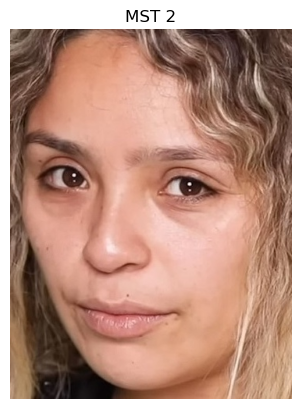

In [64]:
#Printing the RESULT
source_directory = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\A_testing\\input_image'
files = os.listdir(source_directory)
image_path = os.path.join(source_directory, files[0])
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

if predictions is not None:

        top_classes = 3  # Top predicted classes that will be shown
        top_predictions = np.argsort(predictions[0])[-top_classes:][::-1] 
        top_probabilities = predictions[0][top_predictions]  
        
        # Get class labels (Replace with your actual class labels)
        class_labels = ['MST 1', 'MST 2', 'MST 3', 'MST 4', 'MST 5', 'MST 6', 'MST 7', 'MST 8', 'MST 9', 'MST 10']  
        
        # Display predictions
        print("Top Predictions:")
        for i in range(len(top_predictions)):
            class_label = class_labels[top_predictions[i]] if top_predictions[i] < len(class_labels) else f'MST {top_predictions[i]}'
            if lighting == "well": 
                print(f"MST {top_predictions[i] + 2}: {top_probabilities[i]*100:.2f}%")
            else:
                print(f"MST {top_predictions[i] + 1}: {top_probabilities[i]*100:.2f}%")

print(top_predictions+1)
plt.imshow(image)
if lighting == "well":
    plt.title(f'MST {top_predictions[0] + 2}')
else:
    plt.title(f'MST {top_predictions[0] + 1}')
plt.axis('off') 
plt.show()

Top Predictions:
MST 2: 99.54%
MST 5: 0.44%
MST 4: 0.01%
[2 5 4]
4


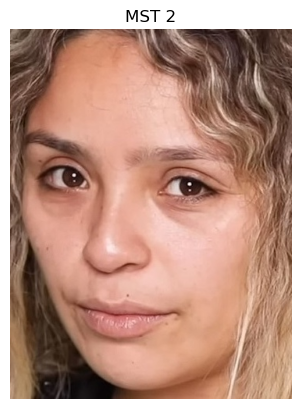

In [65]:
source_directory = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\A_testing\\input_image'
files = os.listdir(source_directory)
image_path = os.path.join(source_directory, files[0])
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

if predictions is not None:

        top_classes = 3  # Top predicted classes that will be shown
        top_predictions = np.argsort(predictions[0])[-top_classes:][::-1] 
        top_probabilities = predictions[0][top_predictions]  
        
        # Get class labels (Replace with your actual class labels)
        class_labels = ['MST 1', 'MST 2', 'MST 3', 'MST 4', 'MST 5', 'MST 6', 'MST 7', 'MST 8', 'MST 9', 'MST 10']  
        
        # Display predictions
        print("Top Predictions:")
        for i in range(len(top_predictions)):
            class_label = class_labels[top_predictions[i]] if top_predictions[i] < len(class_labels) else f'MST {top_predictions[i]}'
            print(f"{class_label}: {top_probabilities[i]*100:.2f}%")

print(top_predictions+1)

plt.imshow(image)
plt.title(f'MST {top_predictions[0] + 1}') 
plt.axis('off') 
print(top_predictions[1])
plt.show()

Code To Empty Folders

In [66]:
def delete_files_in_folders(directory_path):
    folders_to_clean = ['input_image', 'face_image', 'face_resized']  # Replace with your folder names

    for folder_name in folders_to_clean:
        folder_path = os.path.join(directory_path, folder_name)
        
        # Check if the folder exists
        if os.path.exists(folder_path) and os.path.isdir(folder_path):

            # Get all files in the folder
            files_in_folder = os.listdir(folder_path)
            
            # Iterate through files and delete them
            for file_name in files_in_folder:
                file_path = os.path.join(folder_path, file_name)
                try:
                    os.remove(file_path)
                    print(f"Deleted: {file_path}")
                except Exception as e:
                    print(f"Error deleting {file_path}: {e}")
        
        else:
            print(f'{folder_name} Does Not Exist!!')

if __name__ == "__main__":
    directory_path = 'E:\\University\\FYP Stuff\\Dataset\\mst-e_data\\A_testing'

In [67]:
delete_files_in_folders(directory_path)

Deleted: E:\University\FYP Stuff\Dataset\mst-e_data\A_testing\input_image\1.jpg
Deleted: E:\University\FYP Stuff\Dataset\mst-e_data\A_testing\face_image\1_face0.jpg
Deleted: E:\University\FYP Stuff\Dataset\mst-e_data\A_testing\face_resized\1_face0.jpg
